In [25]:
# %conda install numpy
# %pip install tensorflow
# %pip install keras
# %conda install matplotlib
# %conda install pandas
# %conda install gc
# %conda install tifffile
# %pip install -U scikit-learn
# %conda install -c conda-forge gdal
# %conda install imageio
# %pip install opencv-python
# %pip install xeus-python
# %pip install rasterio

import rasterio
import time
import os
import numpy as np  # for arrays
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile  # The input images are in .tiff format and can be parsed using this library
import tensorflow.keras as keras
from PIL import Image
import matplotlib.patches as mpatches
import copy
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

# for bulding and running deep learning model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l2
 
import matplotlib.colors
import pandas as pd


In [26]:
def LoadData(path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    """
    # Read the images folder like a list
    mask_dataset = os.listdir(path2)
    image_dataset = os.listdir(path1)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        if file.endswith('.tif'):
            orig_img.append(file)
    for file in mask_dataset:
        if file.endswith('.tif'):
            mask_img.append(file)

    # Sort the lists to get both of them in same order
    orig_img.sort()
    mask_img.sort()
    return orig_img, mask_img

In [27]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [28]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)  # number of images
    i_h, i_w, i_c = target_shape_img   # pull height, width, and channels of image
    m_h, m_w, m_c = target_shape_mask  # pull height, width, and channels of mask
    # print(target_shape_mask)

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (10 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        image = tifffile.imread(path)
        # image = image.resize((i_h,i_w))
        image = np.reshape(image, (i_h, i_w, i_c))

        # NEED TO UPDATE NORMALIZATION: e.g. get max value of each band
        # image = image/256
        X[index] = image

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        # print(single_mask_ind)
        # print(path2)
        path = os.path.join(path2, single_mask_ind)
        # print(path)
        mask_arr = Image.open(path)
        mask_arr = mask_arr.resize((m_h, m_w))
        mask_arr = np.reshape(mask_arr, (m_h, m_w, m_c))
        # mask_resized = np.expand_dims(mask_arr, axis=2)
        y[index] = mask_arr

    return X, y

In [29]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, L2factor=0.1, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool,
    relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer
    along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization
    # Proper initialization prevents from the problem
    # of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that
    # the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_regularizer=l2(L2factor),
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_regularizer=l2(L2factor),
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based
    # on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the l oss and gradient
    # computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels
    # Pooling has been kept as optional as the last encoder layer
    # does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output
    # computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer
    # to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

In [30]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size
    up = Conv2DTranspose(
                 n_filters,
                 (3, 3),  # Kernel size
                 strides=(2, 2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization 
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv

In [31]:
def UNetCompiled(input_size=(64, 64, 12), n_filters=32, n_classes=2):
    """"
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, L2factor=0.1, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters*2, dropout_prob=0, L2factor=0.1, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4, dropout_prob=0, L2factor=0.1, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8, dropout_prob=0.3, L2factor=0.1, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, L2factor=0.1, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)
    
    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    # sigmoid converts negative values to 0 (predictions between 0-1)
    conv10 = Conv2D(n_classes, 1, padding='same', activation=activation)(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [32]:
# VISUALIZE
def VisualizeResults(index, dataset_x, dataset_y, y_test_file, cmap, title, type = 'mask', save='False'):
    label_file = y_test_file[x]
    print(label_file)
    predict_array = y_test_mono[x]
    
    img = dataset_x[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    
    predictions = pred_y[0,:,:,1][..., tf.newaxis]
    predictions_unknown = pred_y[0,:,:,0][..., tf.newaxis]
    predictions_not_cocoa = pred_y[0,:,:,2][..., tf.newaxis]
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    cocoa_threshold = tf.where(predictions>0.65, 1, 0)
    
    # save geotiffs
    if save=='True':
        predict_array = np.reshape(pred_mask,(1,128,128))
        prob_array = np.reshape(predictions,(1,128,128))
        unknown_prob_array = np.reshape(predictions_unknown,(1,128,128))
        not_cocoa_prob_array = np.reshape(predictions_not_cocoa,(1,128,128))

        with rasterio.open(f'../thesis_data/{dataset}/{type}/{label_file}', 'r') as src:
            output_predict = f'{dataset}/{dataset}_{fold}_predict_{type}_{label_file}'
            output_prob = f'{dataset}/{dataset}_{fold}_prob_{type}_{label_file}'
            output_prob_unknown = f'{dataset}/{dataset}_{fold}_prob_{type}_{label_file}_unknown'
            output_prob_not_cocoa = f'{dataset}/{dataset}_{fold}_prob_{type}_{label_file}_not_cocoa'
            label_meta = src.meta.copy()
            print(label_meta)

        with rasterio.open(output_predict, 'w', **label_meta) as dst:
            dst.write(predict_array)

        label_meta.update({
           'dtype': 'float32'
        })

        with rasterio.open(output_prob, 'w', **label_meta) as dst:
            dst.write(prob_array)
        with rasterio.open(output_prob_unknown, 'w', **label_meta) as dst:
            dst.write(unknown_prob_array)
        with rasterio.open(output_prob_not_cocoa, 'w', **label_meta) as dst:
            dst.write(not_cocoa_prob_array)
    
    fig, arr = plt.subplots(1, 3, figsize=(8,8))
    fig.tight_layout()
    
    arr[0].imshow(dataset_y[index, :, :, 0], cmap = cmap, vmin=0, vmax=2)
    arr[0].set_title('Ground truth', fontsize=7)
    arr[0].axis('off')
    
    arr[1].imshow(predictions[:, :, 0], cmap, vmin=0, vmax=1)
    arr[1].set_title('Cocoa probability map', fontsize=7)
    im = arr[1].imshow(predictions[:, :, 0], cmap='YlGn', vmin=0, vmax=1)
    arr[1].axis('off')
    
    arr[2].imshow(pred_mask, cmap = cmap, vmin=0, vmax=2)
    arr[2].set_title('Prediction map', fontsize=7)
    arr[2].axis('off')

    plt.show()
    


In [33]:
# Custom IoU that applies argmax before computing
class UpdatedIoU(tf.keras.metrics.IoU):
  def init(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None,
               target_class_ids=None,
               ignore_class=None):
    super(UpdatedIoU, self).__init__(num_classes=num_classes,
                                     target_class_ids=target_class_ids,
                                     ignore_class=ignore_class,
                                     name=name,
                                     dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.reshape(y_true, shape=(-1, 128, 128))
    # apply mask to exclude unknown regions
    y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
    return super().update_state(y_true, y_pred, sample_weight)

In [35]:
# Custom IoU that applies argmax before computing
class UpdatedPrecision(tf.keras.metrics.Precision):
  def init(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None, 
               dtype=None):
    super(UpdatedPrecision, self).__init__(num_classes=num_classes,
                                     target_class_ids=target_class_ids,
                                     ignore_class=ignore_class,
                                     name=name,
                                     dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.reshape(y_true, shape=(-1, 128, 128))
    # apply mask to exclude unknown regions
    y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
    return super().update_state(y_true, y_pred, sample_weight)

In [36]:
def recall(y_true, y_pred):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.reshape(y_true, shape=(-1, 128, 128))
    # apply mask to exclude unknown regions
    y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    
    true_positives = K.sum(tf.where(y_true*y_pred==1, y_true, 0))
    possible_positives = K.sum(tf.where(y_true==1, y_true, 0))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    
    return recall_keras


In [37]:
def precision(y_true, y_pred):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.reshape(y_true, shape=(-1, 128, 128))
    # apply mask to exclude unknown regions
    y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    
    true_positives = K.sum(tf.where(y_true*y_pred==1, y_true, 0))
    predicted_positives = K.sum(tf.where(y_pred==1, y_pred, 0))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    
    return precision_keras

In [38]:
def custom_accuracy(y_true, y_pred):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_true = tf.reshape(y_true, shape=(-1, 128, 128))
    # apply mask to exclude unknown regions
    y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    
    true_positives_cocoa = K.sum(tf.where(y_true*y_pred==1, 1, 0))
    true_positives_forest = K.sum(tf.where(y_true*y_pred==4, 1, 0))
    total_predictions = K.sum(tf.where(y_true == 0, 0, 1))
    
    accuracy = (true_positives_cocoa+true_positives_forest)/total_predictions
    return accuracy

In [40]:
# Custom loss function with weights and mask
def loss_with_weights(class_weight):
    def loss(y_true, y_pred):
        
        label_weights = tf.gather(class_weight, y_true)
        flat_output = tf.reshape(y_pred, (-1, len(class_weight)))
        flat_labels = tf.reshape(y_true, (-1,))
        flat_label_weights = tf.reshape(label_weights, (-1,))
        # print("Y_true: ", flat_labels)
        # print("Y_pred: ", flat_output)
        
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    
        loss = loss_fn(flat_labels, flat_output, sample_weight=flat_label_weights)
        return loss
    return loss

In [41]:
""" Load Train Set and view some examples """
# Call the apt function
dataset = 'dec_MSI_temp_SAR_cloudless'
path1 = f'../thesis_data/{dataset}/satellite/'
path2 = f'../thesis_data/{dataset}/mask/'

path1_inter = f'../thesis_data/{dataset}/inter_satellite/'
path2_inter = f'../thesis_data/{dataset}/inter_mask/'
# returns sorted list of (1) image paths and (2) corresponding label paths

img, mask = LoadData(path1, path2)
img_inter, mask_inter = LoadData(path1_inter, path2_inter)
# View an example of image and corresponding mask
# i = 0
# img_view  = tifffile.imread(path1 + img[i])
# mask_view = tifffile.imread(path2 + mask[i])
# # print(img_view.shape)
# # print(mask_view.shape)
# fig, arr = plt.subplots(1, 2, figsize=(15, 15))
# # just view band 1 of satellite image
# # arr[0].imshow(img_view[:,:,5])
# # arr[0].set_title('Image '+ str(i))

# arr[1].imshow(mask_view, cmap = cmap,  vmin=0, vmax=2)
# arr[1].set_title('Masked Image '+ str(i))

In [42]:
# Define the desired shape: depends on number of channels and size
# UPDATE WHEN STACKING SAR OR TEMP DATA
n_classes = 3
n_channels = 14
size = 128

target_shape_img = [size, size, n_channels]
target_shape_mask = [size, size, 1]

X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

X_inter, y_inter = PreprocessData(img_inter, mask_inter, target_shape_img, target_shape_mask, path1_inter, path2_inter) 

count_cocoa = np.count_nonzero(y == 1)
count_forest = np.count_nonzero(y == 2)

total_labelled = count_cocoa+count_forest
percent_cocoa = count_cocoa/total_labelled
print(f'total labelled pixels:{total_labelled}\n percent_cocoa: {percent_cocoa}')
    
# QC the shape of output and classes in output dataset 
# print("X Shape:", X.shape)
# print("Y shape:", y.shape)

# # Visualize the output
# image_index = 16
# fig, arr = plt.subplots(1, 2, figsize=(15, 15))
# arr[0].imshow(y_inter[image_index,:,:,0], cmap = cmap, vmin=0, vmax=3)
# arr[0].set_title('Processed Masked Image ')

total labelled pixels:3975792
 percent_cocoa: 0.14708415329574587


In [43]:
# Use scikit-learn's function to split the dataset
random=0
# save 10% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random)
X_train_file, X_test_file, y_train_file, y_test_file = train_test_split(img, mask, test_size=0.1, random_state=random)

count_cocoa_label = np.count_nonzero(y_test == 1 )
count_forest_label = np.count_nonzero(y_test == 2 )

total_labelled = count_cocoa_label+count_forest_label
percent_cocoa = count_cocoa_label/total_labelled
print(f'test sample randomization: {random}\n test sample size:{total_labelled}\n test percent_cocoa: {percent_cocoa}')


# convert inter cacao in train/validation dataset to background
# replace 3s with 0s
for i in range(y_train.shape[0]):
    y_train[i, :, :] = tf.where(y_train[i, :, :] == 3, 0, y_train[i, :, :])

skf = KFold(n_splits=10, random_state=30, shuffle=True)

train_indices = []
val_indices = []
for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    # print(f"Fold {i}:")
    # print(f"  Train: number of images={train_index.shape}")
    train_indices.append(train_index)
    # print(f"  Validate:  number of images={val_index.shape}")
    val_indices.append(val_index)

test sample randomization: 0
 test sample size:410894
 test percent_cocoa: 0.151898056433046


In [44]:
# NORMALIZATION
# normalize all data based on training data values.
# several normalization options available
band = 1
for i in range(X_train.shape[3]):
    # print(f"                                 band no: {band}")
    flattened = X_train[:, :, :, i].flatten()
    
    q_1 = np.quantile(flattened, 0.1)
    q_1 = tf.convert_to_tensor(q_1)
    
    q_99 = np.quantile(flattened, 0.99)
    q_99 = tf.convert_to_tensor(q_99)
    
    max_ = flattened.max()
    max_ = tf.convert_to_tensor(max_)
    
    min_ = flattened.min()
    min_ = tf.convert_to_tensor(min_)
    # print(q_1, q_99)
    img=1
    band+=1
    # update this band for each image
    for im in range(X_train.shape[0]):
        # print(f"image no: {img}")
        # print(f"original max: {X_train[im, :, :, i].max()}")
        # print(X_train[im, :, :, i]) 
        
        # normalization
        # max
        # X_train[im, :, :, i] = X_train[im, :, :, i]/max_
        
        # min and max
        X_train[im, :, :, i] = (X_train[im, :, :, i]-min_)*((1-0)/(max_-min_))+0
        
        # percentiles
        # X_train[im, :, :, i] = (X_train[im, :, :, i]-q_1)*((1-0)/(q_99-q_1))+0
        
        # percentiles, bounded
        # X_train[im, :, :, i] = (X_train[im, :, :, i]-q_1)*((1-0)/(q_99-q_1))+0
        # X_train[im, :, :, i] = tf.where(X_train[im, :, :, i]<0, 0, X_train[im, :, :, i])
        # X_train[im, :, :, i] = tf.where(X_train[im, :, :, i]>1, 1, X_train[im, :, :, i])
        
        # print(X_train[im, :, :, i])
        # print(f"new max: {X_train[im, :, :, i].max()}")
        img+=1
    for im in range(X_test.shape[0]):
        # print(f"image no: {img}")
        # print(f"original max: {X_valid[im, :, :, i].max()}")
        # print(X_valid[im, :, :, i]) 
        
        # normalization
        # max
        # X_valid[im, :, :, i] = X_valid[im, :, :, i]/max_
        
        # min and max
        X_test[im, :, :, i] = (X_test[im, :, :, i]-min_)*((1-0)/(max_-min_))+0
        
        # percentiles
        # X_valid[im, :, :, i] = (X_valid[im, :, :, i]-q_1)*((1-0)/(q_99-q_1))+0
        
        # percentiles, bounded
        # X_valid[im, :, :, i] = (X_valid[im, :, :, i]-q_1)*((1-0)/(q_99-q_1))+0
        # X_valid[im, :, :, i] = tf.where(X_valid[im, :, :, i]<0, 0, X_valid[im, :, :, i])
        # X_valid[im, :, :, i] = tf.where(X_valid[im, :, :, i]>1, 1, X_valid[im, :, :, i])
        
        # print(X_valid[im, :, :, i])
        # print(f"new max: {X_valid[im, :, :, i].max()}")
        img+=1
        
    for im in range(X_inter.shape[0]):
        # print(f"image no: {img}")
        # print(f"original max: {X_test[im, :, :, i].max()}")
        # print(X_test[im, :, :, i]) 
        
        # normalization
        # max
        # X_test[im, :, :, i] = X_test[im, :, :, i]/max_
        
        # min and max
        X_inter[im, :, :, i] = (X_inter[im, :, :, i]-min_)*((1-0)/(max_-min_))+0
        
        # percentiles
        # X_test[im, :, :, i] = (X_test[im, :, :, i]-q_1)*((1-0)/(q_99-q_1))+0
        
        # percentiles, bounded
        # X_test[im, :, :, i] = (X_test[im, :, :, i]-q_1)*((1-0)/(q_99-q_1))+0
        # X_test[im, :, :, i] = tf.where(X_test[im, :, :, i]<0, 0, X_test[im, :, :, i])
        # X_test[im, :, :, i] = tf.where(X_test[im, :, :, i]>1, 1, X_test[im, :, :, i])
        
        # print(X_test[im, :, :, i])
        # print(f"new max: {X_test[im, :, :, i].max()}")
        img+=1



In [45]:
# # create test data without intercrop label
# # replace 3s with 0s
y_test_mono = copy.deepcopy(y_test)
for i in range(y_test.shape[0]):
    y_test_mono[i, :, :] = tf.where(y_test_mono[i, :, :] == 3, 0, y_test_mono[i, :, :])

In [46]:
# create intercrop test mask 
# replace 3s with 1s
for i in range(y_inter.shape[0]):
    y_inter[i, :, :] = tf.where(y_inter[i, :, :] == 3, 1, y_inter[i, :, :])

In [47]:
# create report
report = {'dataset': [], 'fold':[], 'runtime':[],'training_images':[], 'val_images':[], 'weights':[],
          'monocrop_loss':[],
         'monocrop_IOU':[], 'monocrop_precision':[], 'monocrop_recall':[],
         'monocrop_accuracy':[], 'intercrop_loss':[], 'intercrop_IOU':[],
         'intercrop_recall':[], 'intercrop_accuracy':[]}

Epoch 1/300
14/14 [==============================] - ETA: 0s - loss: 512.3595 - IOU: 0.1610 - recall: 0.6227 - precision: 0.2201 - custom_accuracy: 0.4624
Epoch 1: val_loss improved from inf to 268.62204, saving model to checkpoint_dec_MSI_temp_SAR_cloudless_0/cp.ckpt
14/14 [==============================] - 16s 621ms/step - loss: 512.3595 - IOU: 0.1610 - recall: 0.6227 - precision: 0.2201 - custom_accuracy: 0.4624 - val_loss: 268.6220 - val_IOU: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_custom_accuracy: 0.8573
Epoch 2/300
14/14 [==============================] - ETA: 0s - loss: 176.1988 - IOU: 0.1297 - recall: 0.4646 - precision: 0.1674 - custom_accuracy: 0.5551
Epoch 2: val_loss improved from 268.62204 to 99.74030, saving model to checkpoint_dec_MSI_temp_SAR_cloudless_0/cp.ckpt
14/14 [==============================] - 8s 574ms/step - loss: 176.1988 - IOU: 0.1297 - recall: 0.4646 - precision: 0.1674 - custom_accuracy: 0.5551 - val_loss: 99.7403 - val_IOU: 0

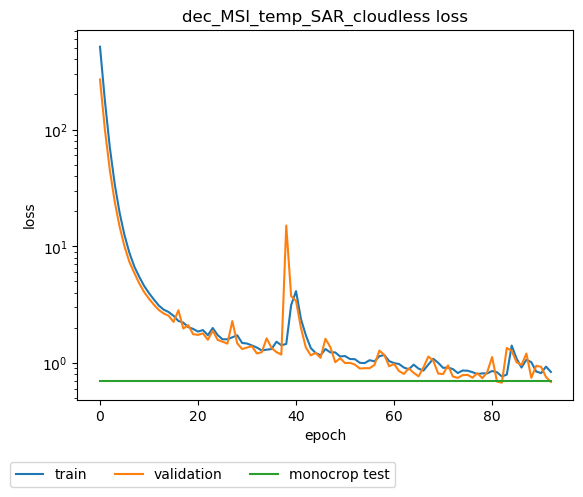

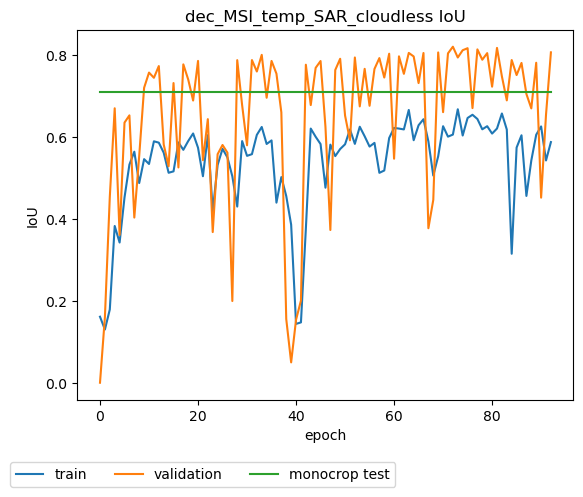

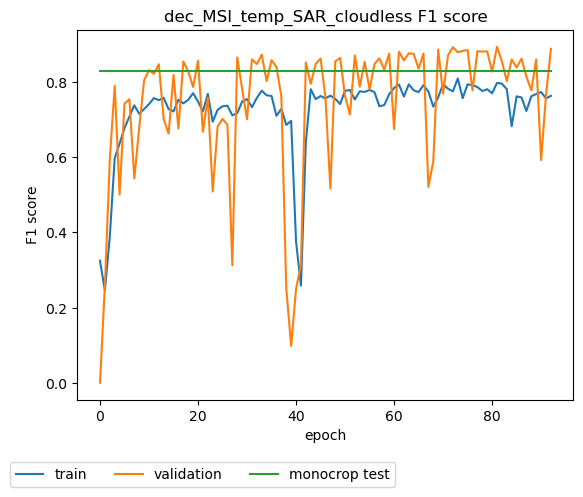

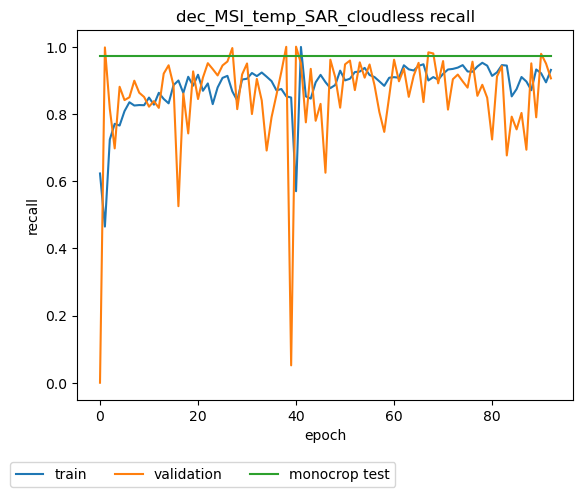

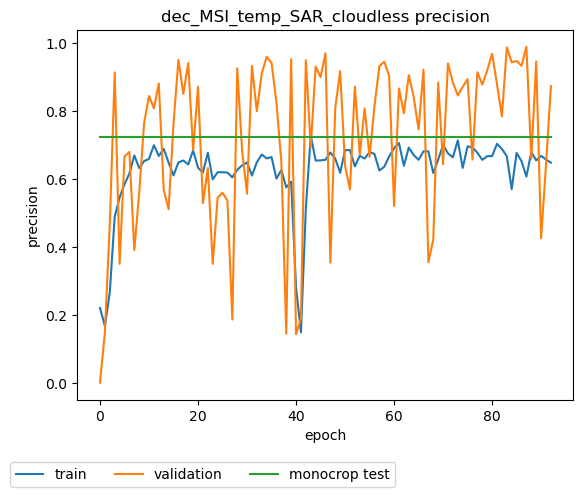

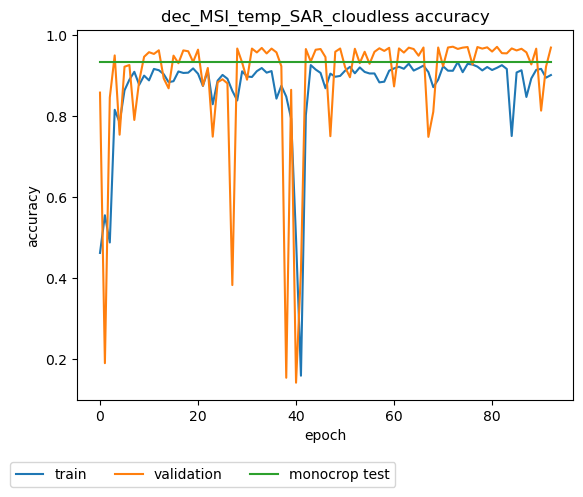

{'dataset': ['dec_MSI_temp_SAR_cloudless'], 'fold': [0], 'runtime': [684.0610237121582], 'training_images': [434], 'val_images': [49], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753]], 'monocrop_loss': [0.6954670548439026], 'monocrop_IOU': [0.709246814250946], 'monocrop_precision': [0.9713348150253296], 'monocrop_recall': [0.7245800495147705], 'monocrop_accuracy': [0.9337916374206543], 'intercrop_loss': [0.46942681074142456], 'intercrop_IOU': [0.9521076083183289], 'intercrop_recall': [0.9562491178512573], 'intercrop_accuracy': [0.9562491178512573]}
Fold #0 done!
Epoch 1/300
14/14 [==============================] - ETA: 0s - loss: 512.1030 - IOU: 0.1298 - recall: 0.4848 - precision: 0.1571 - custom_accuracy: 0.4999
Epoch 1: val_loss improved from inf to 268.66287, saving model to checkpoint_dec_MSI_temp_SAR_cloudless_1/cp.ckpt
14/14 [==============================] - 17s 620ms/step - loss: 512.1030 - IOU: 0.1298 - recall: 0.4848 - precision: 0.1571 - custom_accur

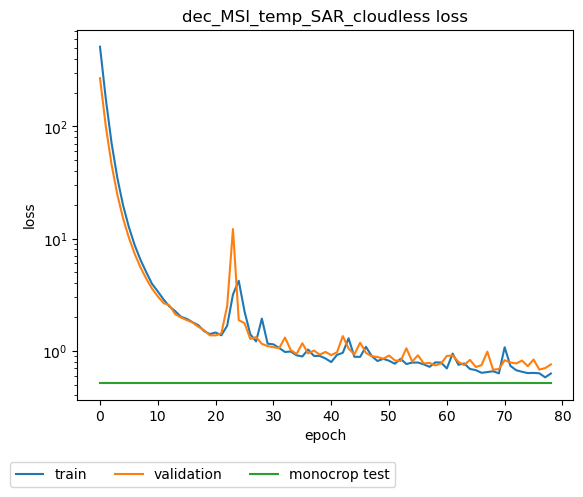

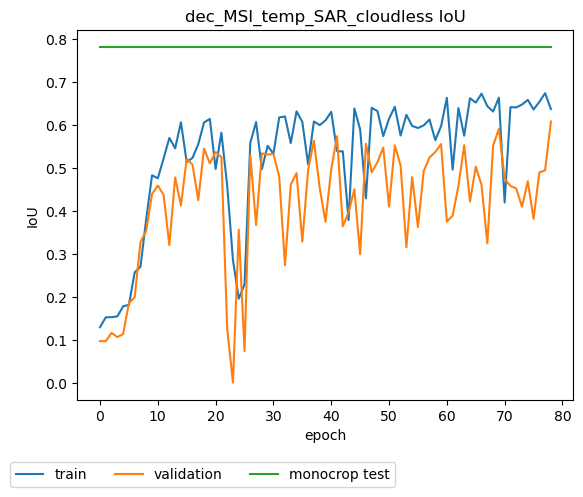

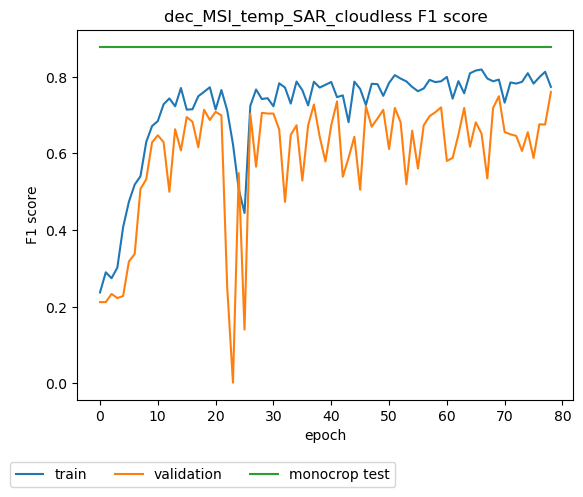

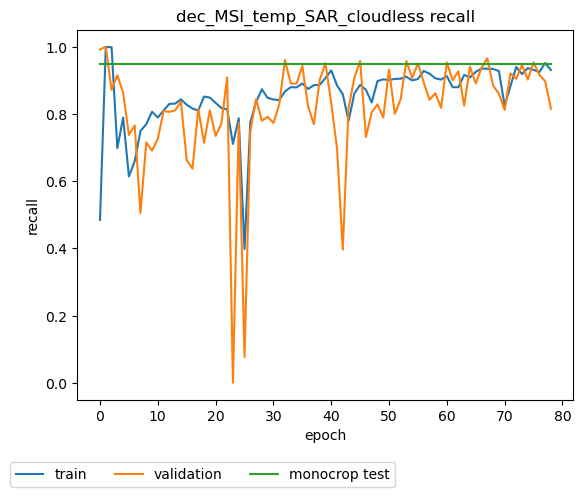

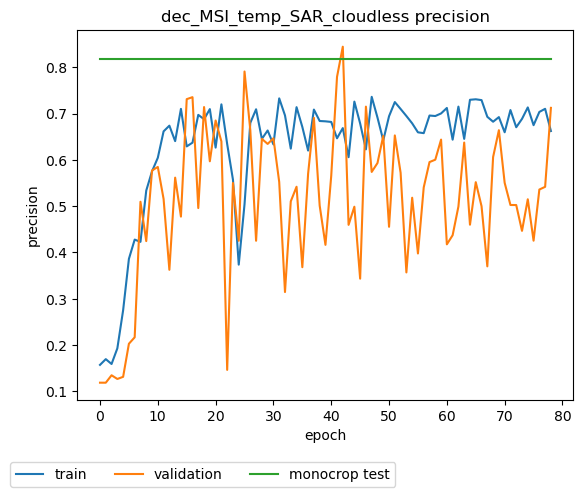

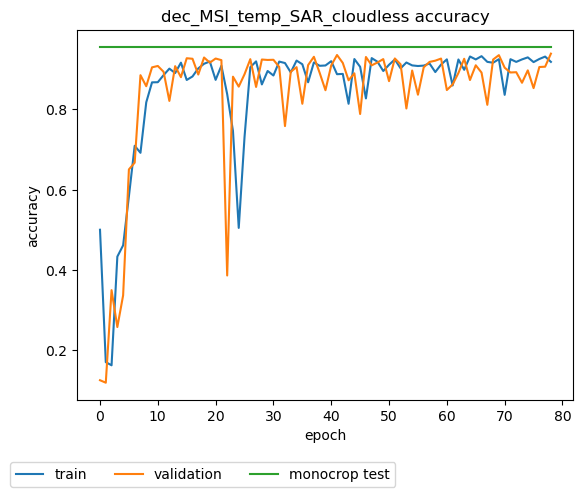

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1], 'runtime': [684.0610237121582, 586.1840198040009], 'training_images': [434, 434], 'val_images': [49, 49], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445]], 'monocrop_loss': [0.6954670548439026, 0.5196754932403564], 'monocrop_IOU': [0.709246814250946, 0.7825868725776672], 'monocrop_precision': [0.9713348150253296, 0.9496318101882935], 'monocrop_recall': [0.7245800495147705, 0.8167633414268494], 'monocrop_accuracy': [0.9337916374206543, 0.956073522567749], 'intercrop_loss': [0.46942681074142456, 0.33826595544815063], 'intercrop_IOU': [0.9521076083183289, 0.8665816187858582], 'intercrop_recall': [0.9562491178512573, 0.8926641941070557], 'intercrop_accuracy': [0.9562491178512573, 0.8926641941070557]}
Fold #1 done!
Epoch 1/300
14/14 [==============================] - ETA: 0s - loss: 516.4677 - IOU: 0.0915 - recall: 0.

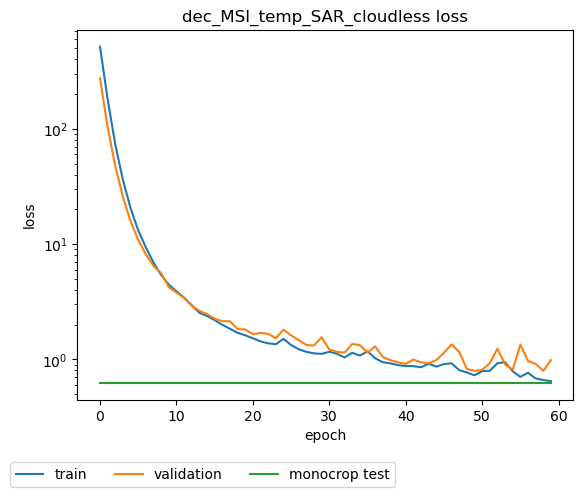

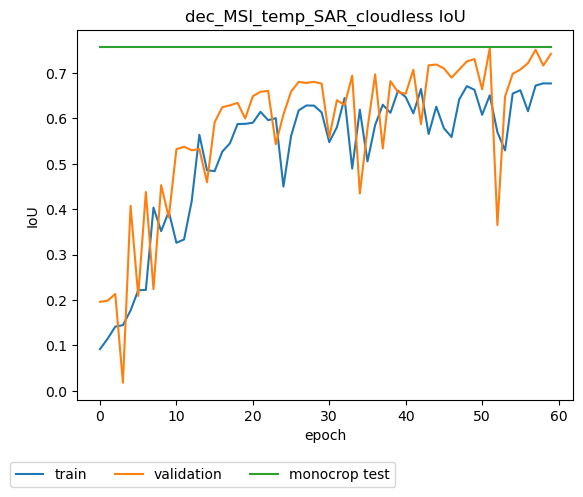

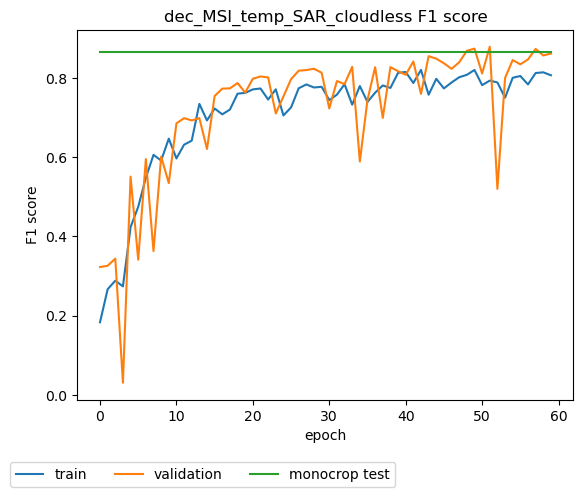

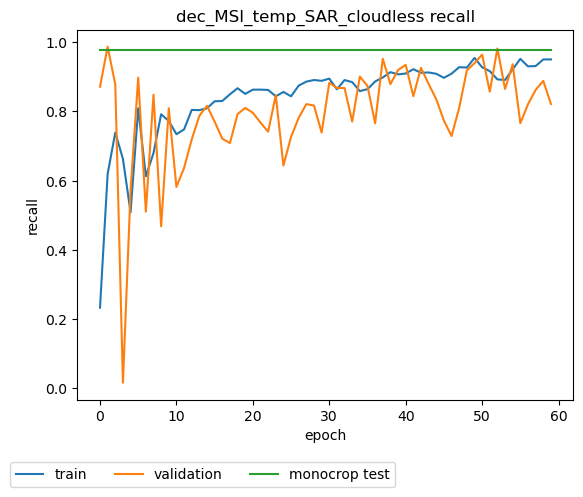

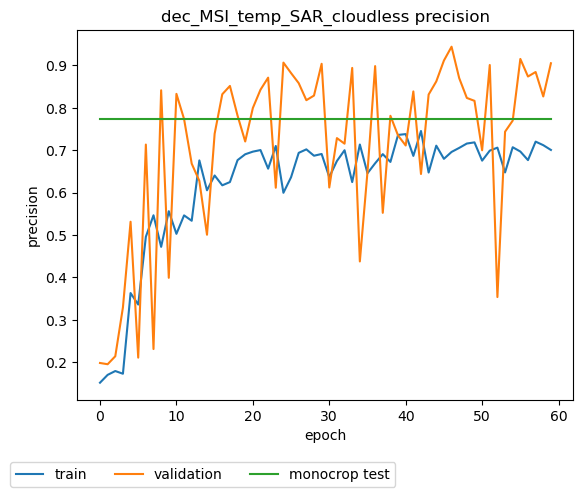

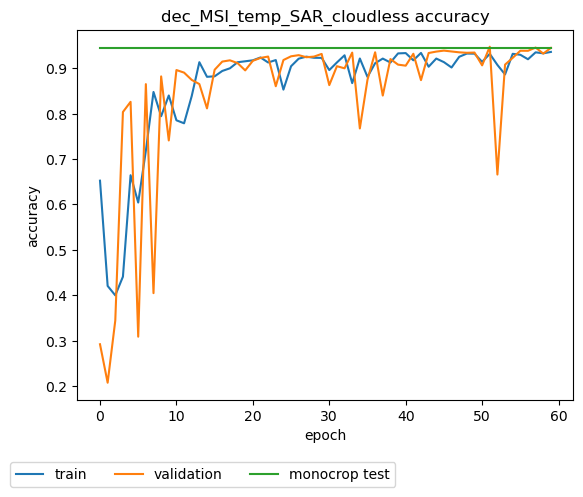

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749], 'training_images': [434, 434, 434], 'val_images': [49, 49, 49], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362]], 'monocrop_loss': [0.6954670548439026, 0.5196754932403564, 0.6266663670539856], 'monocrop_IOU': [0.709246814250946, 0.7825868725776672, 0.7578837275505066], 'monocrop_precision': [0.9713348150253296, 0.9496318101882935, 0.9772785902023315], 'monocrop_recall': [0.7245800495147705, 0.8167633414268494, 0.7741264700889587], 'monocrop_accuracy': [0.9337916374206543, 0.956073522567749, 0.9454962015151978], 'intercrop_loss': [0.46942681074142456, 0.33826595544815063, 0.43975022435188293], 'intercrop_IOU': [0.9521076083183289, 0.8665816187858582, 0.

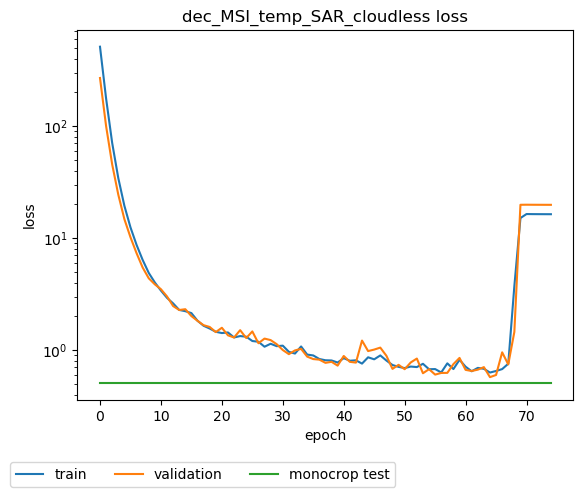

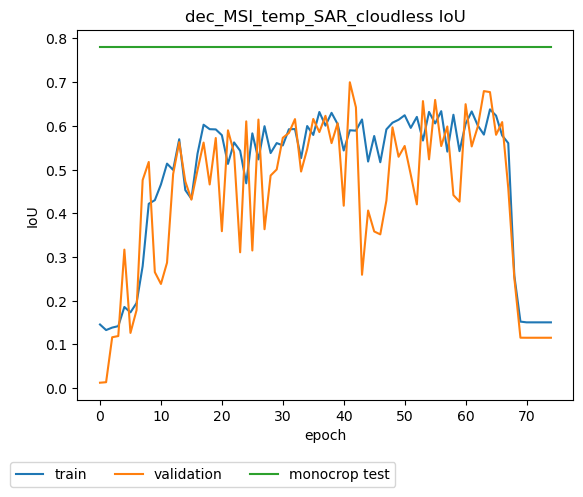

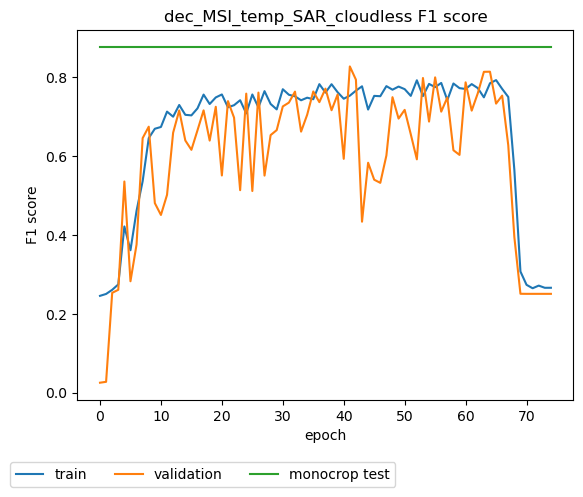

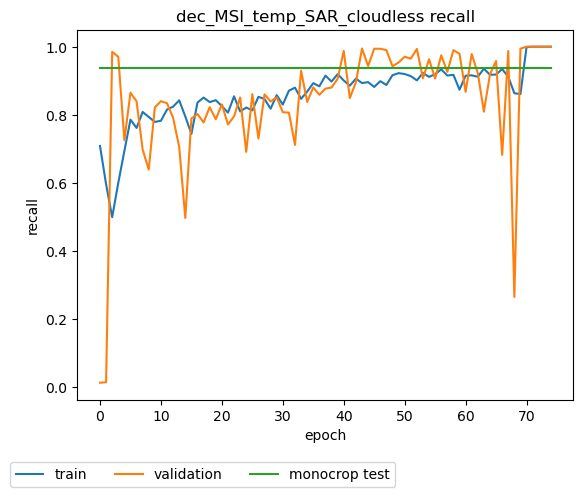

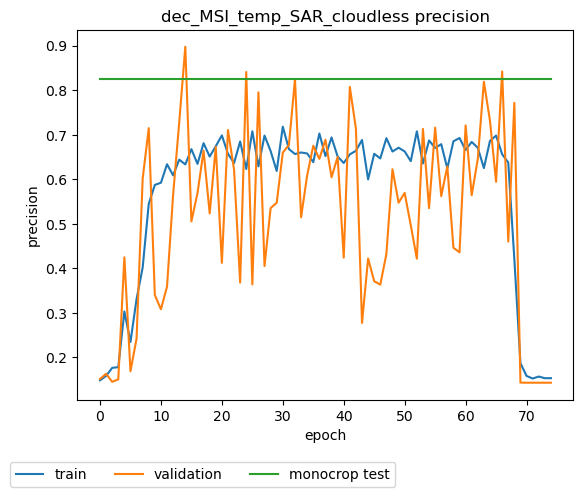

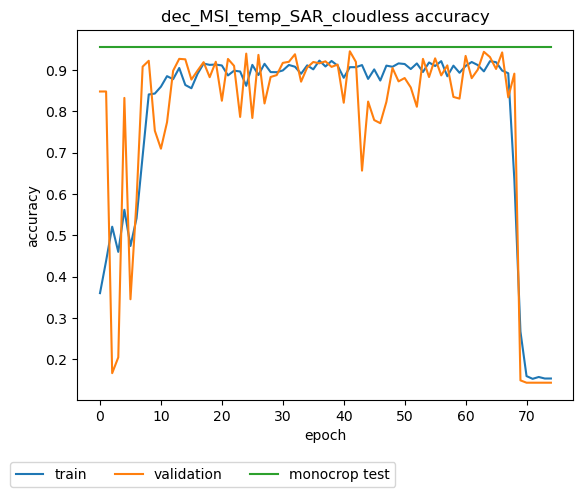

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2, 3], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749, 608.7769820690155], 'training_images': [434, 434, 434, 435], 'val_images': [49, 49, 49, 48], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362], [1.795680564657365, 14.990188180806692, 2.6567638434624294]], 'monocrop_loss': [0.6954670548439026, 0.5196754932403564, 0.6266663670539856, 0.5115991234779358], 'monocrop_IOU': [0.709246814250946, 0.7825868725776672, 0.7578837275505066, 0.781129777431488], 'monocrop_precision': [0.9713348150253296, 0.9496318101882935, 0.9772785902023315, 0.9367437958717346], 'monocrop_recall': [0.7245800495147705, 0.8167633414268494, 0.7741264700889587, 0.8249322772026062], 'monocrop_accuracy': [0.

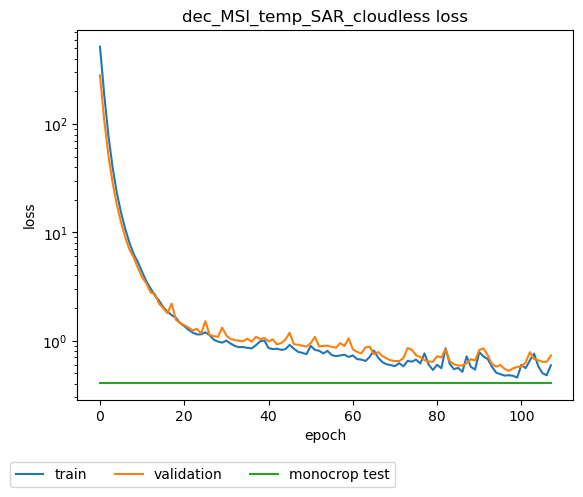

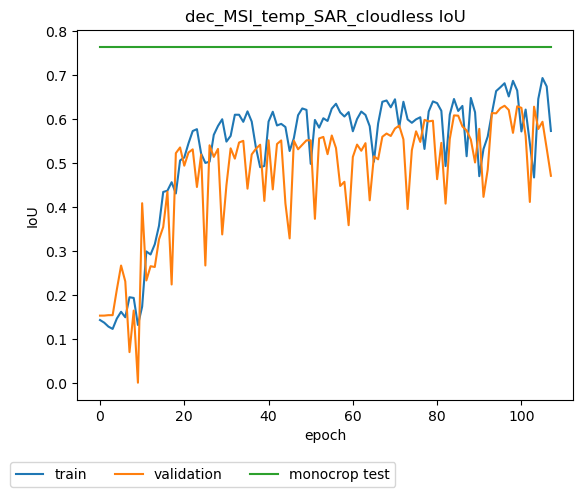

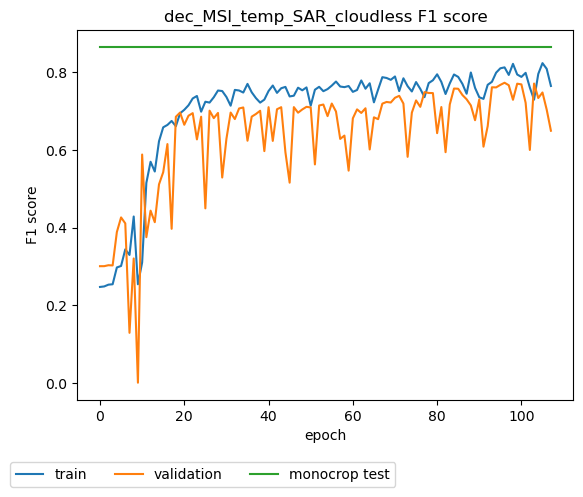

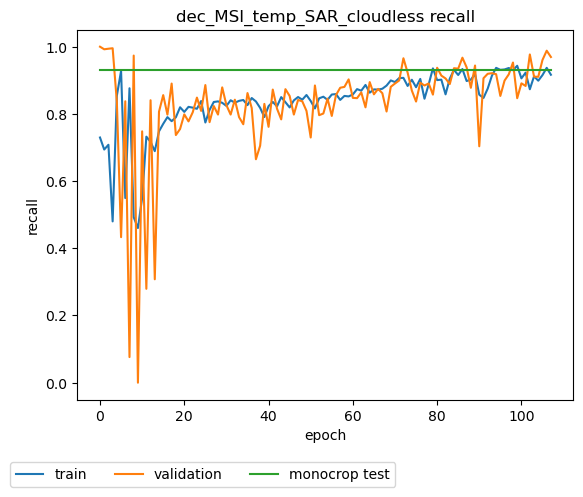

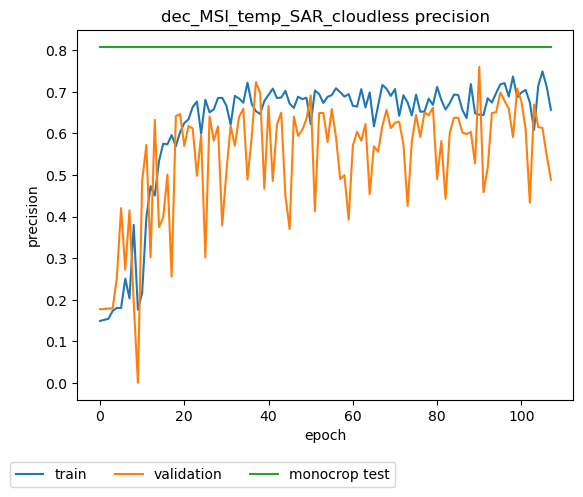

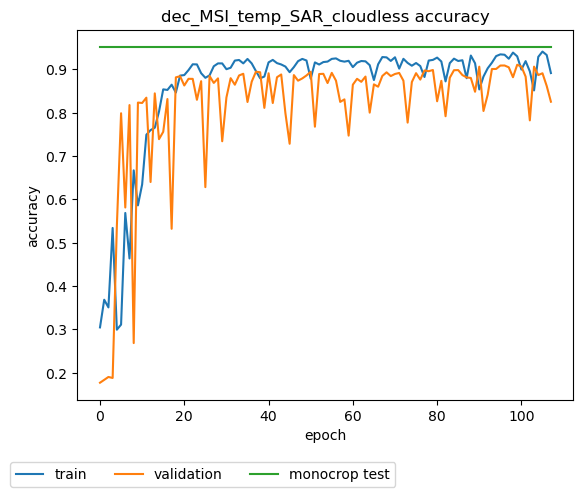

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2, 3, 4], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749, 608.7769820690155, 836.2570259571075], 'training_images': [434, 434, 434, 435, 435], 'val_images': [49, 49, 49, 48, 48], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362], [1.795680564657365, 14.990188180806692, 2.6567638434624294], [1.8243774574049805, 15.168207173519313, 2.591073335289261]], 'monocrop_loss': [0.6954670548439026, 0.5196754932403564, 0.6266663670539856, 0.5115991234779358, 0.40971019864082336], 'monocrop_IOU': [0.709246814250946, 0.7825868725776672, 0.7578837275505066, 0.781129777431488, 0.7635375261306763], 'monocrop_precision': [0.9713348150253296, 0.9496318101882935, 0.9

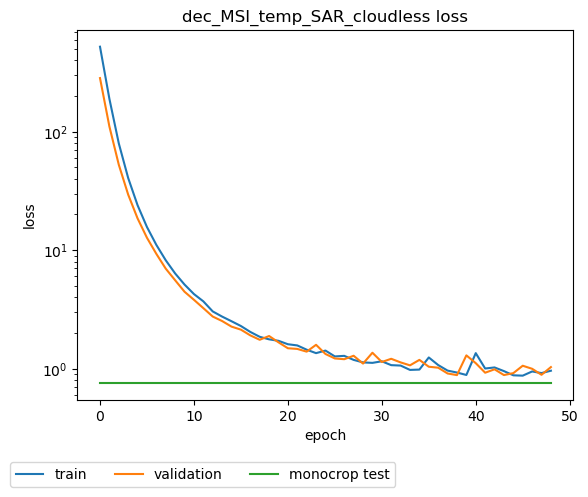

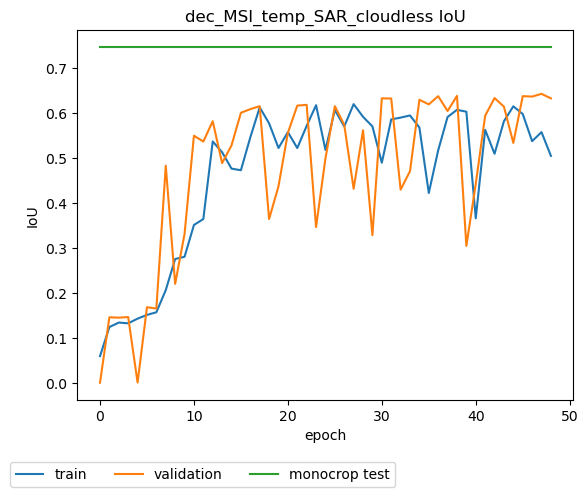

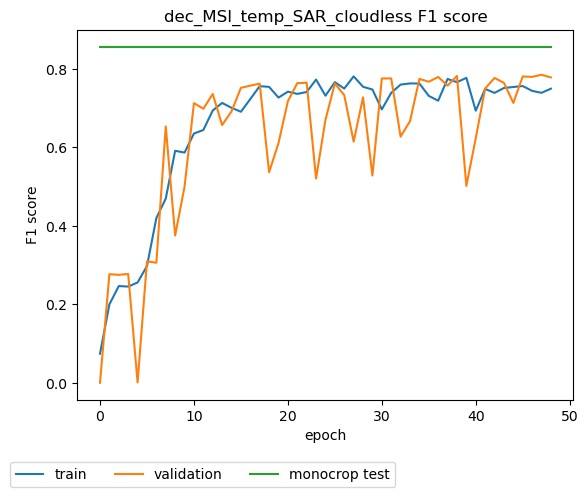

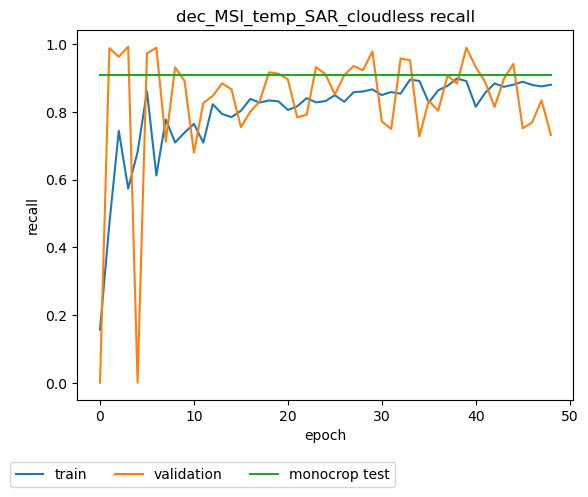

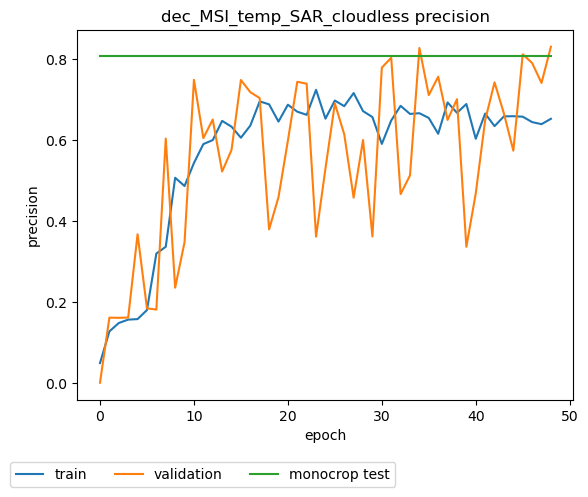

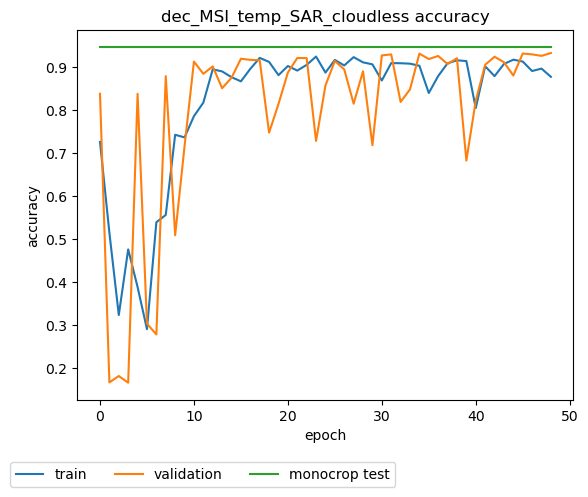

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2, 3, 4, 5, 6], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749, 608.7769820690155, 836.2570259571075, 1092.3287844657898, 386.67276906967163], 'training_images': [434, 434, 434, 435, 435, 435, 435], 'val_images': [49, 49, 49, 48, 48, 48, 48], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362], [1.795680564657365, 14.990188180806692, 2.6567638434624294], [1.8243774574049805, 15.168207173519313, 2.591073335289261], [1.8533377575337096, 15.333991699423605, 2.530246877859026], [1.821835368049834, 15.124334189249412, 2.5975080536147144]], 'monocrop_loss': [0.6954670548439026, 0.5196754932403564

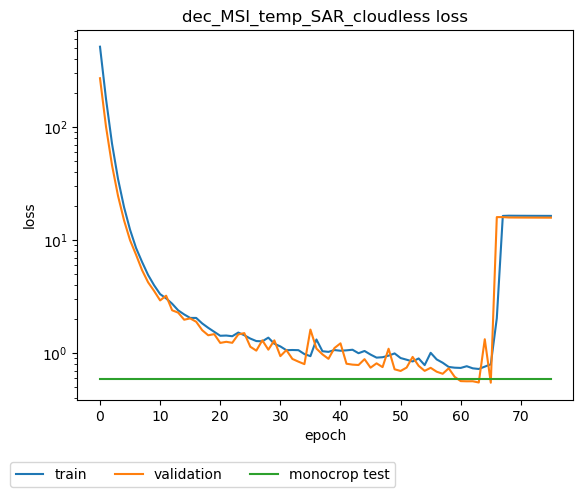

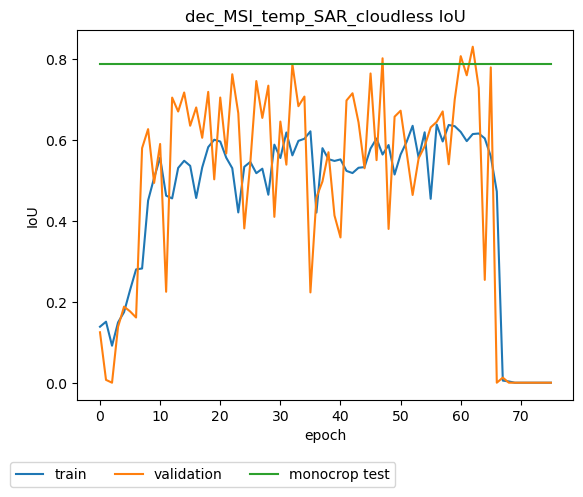

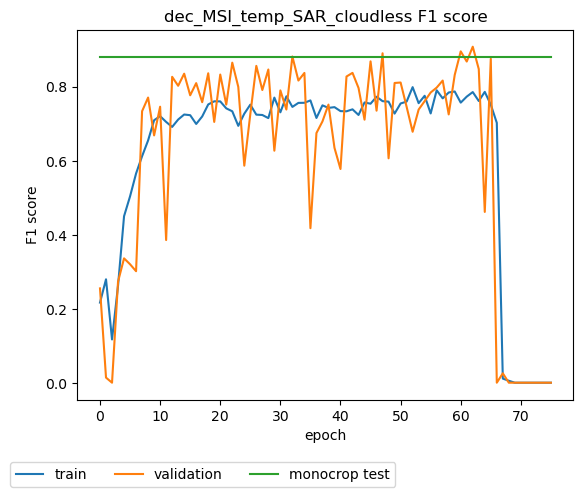

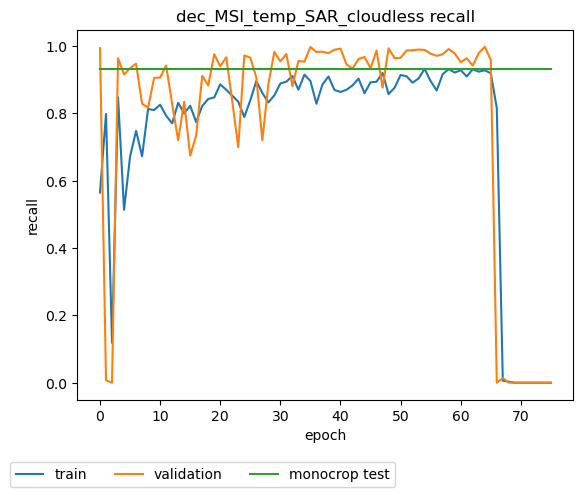

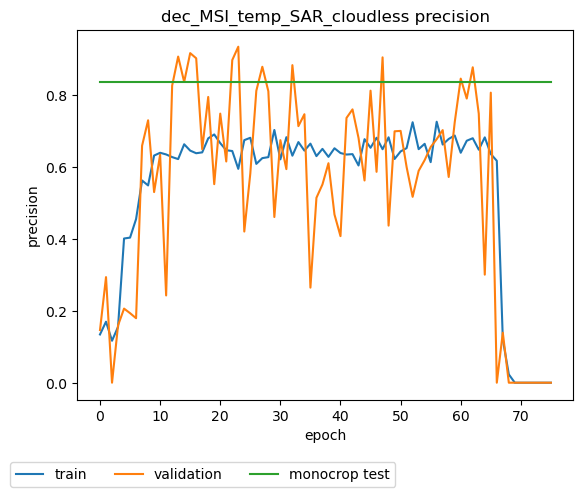

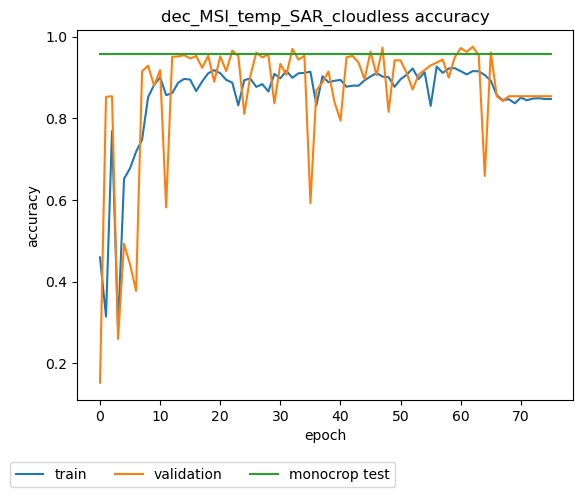

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2, 3, 4, 5, 6, 7], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749, 608.7769820690155, 836.2570259571075, 1092.3287844657898, 386.67276906967163, 583.6351091861725], 'training_images': [434, 434, 434, 435, 435, 435, 435, 435], 'val_images': [49, 49, 49, 48, 48, 48, 48, 48], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362], [1.795680564657365, 14.990188180806692, 2.6567638434624294], [1.8243774574049805, 15.168207173519313, 2.591073335289261], [1.8533377575337096, 15.333991699423605, 2.530246877859026], [1.821835368049834, 15.124334189249412, 2.597508053614714

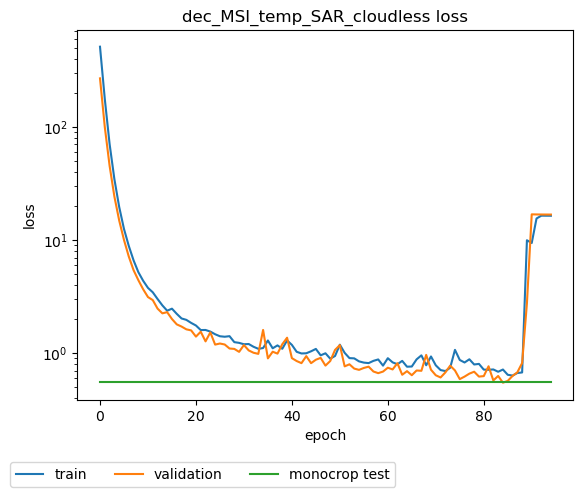

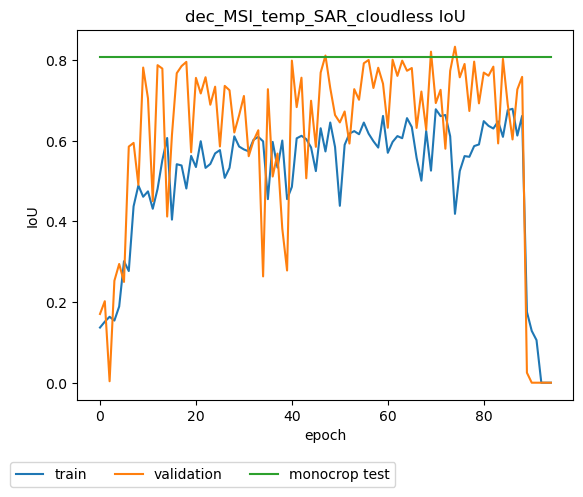

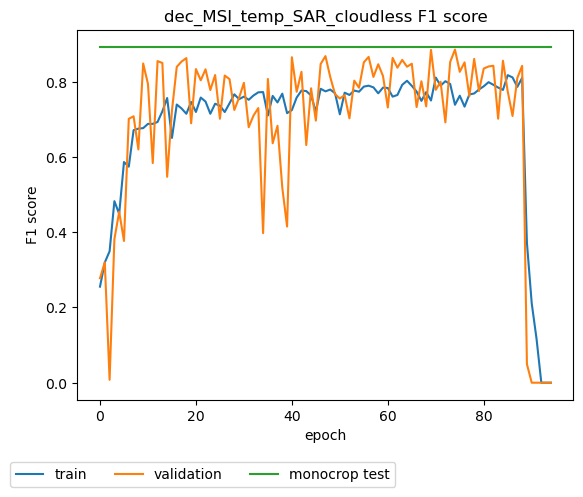

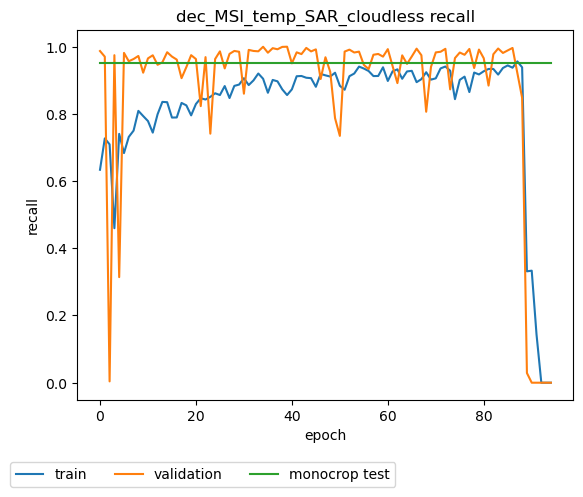

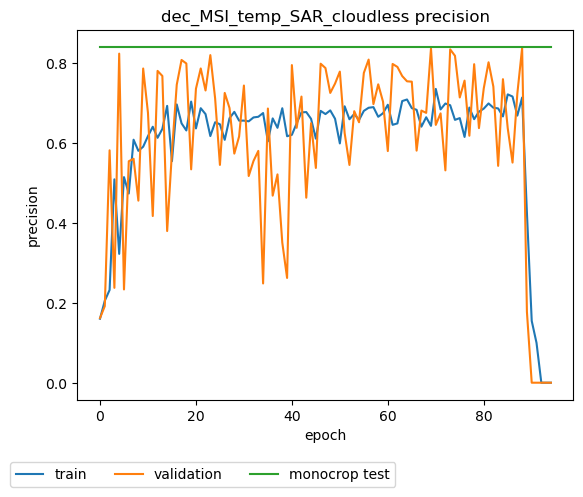

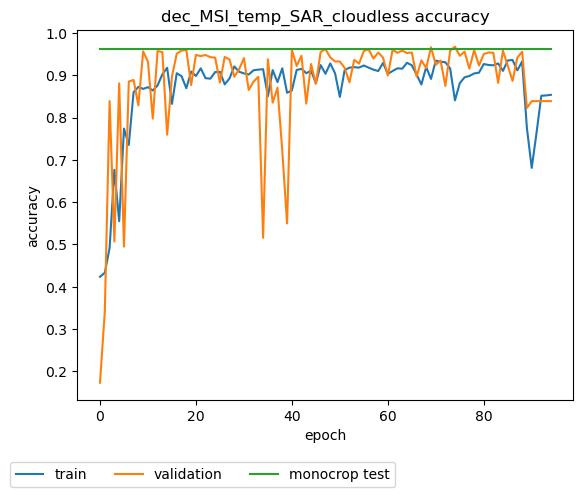

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749, 608.7769820690155, 836.2570259571075, 1092.3287844657898, 386.67276906967163, 583.6351091861725, 739.1121408939362], 'training_images': [434, 434, 434, 435, 435, 435, 435, 435, 435], 'val_images': [49, 49, 49, 48, 48, 48, 48, 48, 48], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362], [1.795680564657365, 14.990188180806692, 2.6567638434624294], [1.8243774574049805, 15.168207173519313, 2.591073335289261], [1.8533377575337096, 15.333991699423605, 2.53024687785902

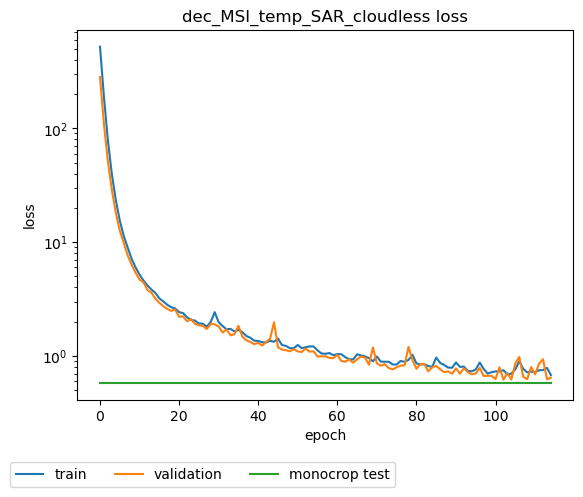

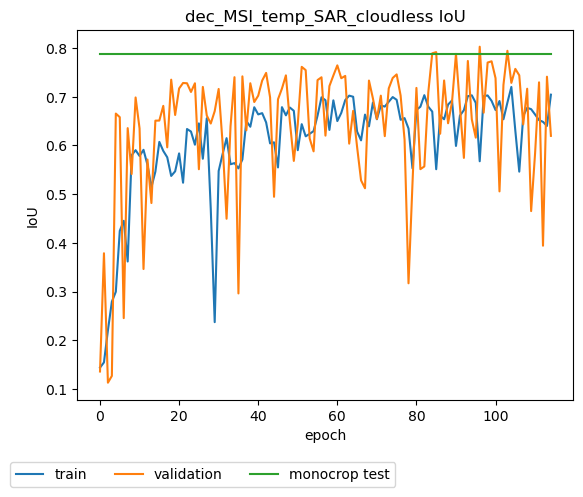

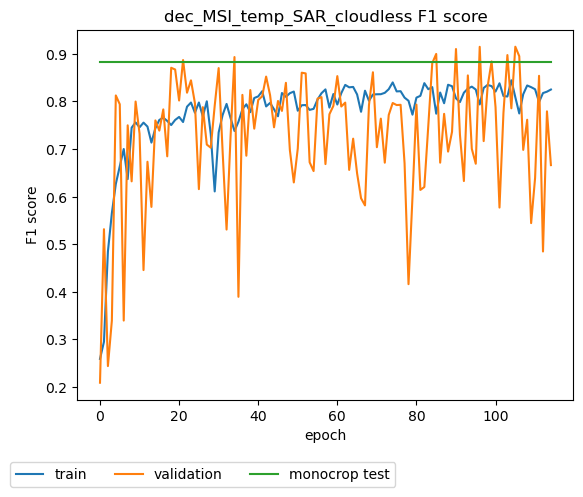

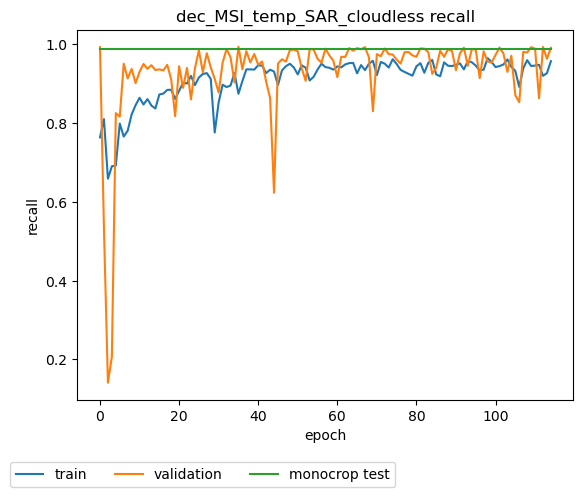

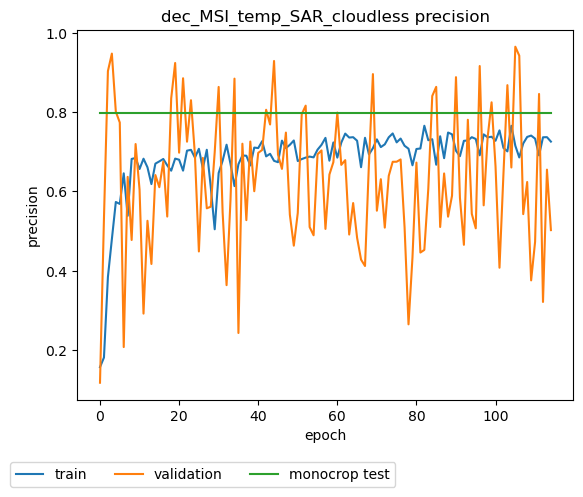

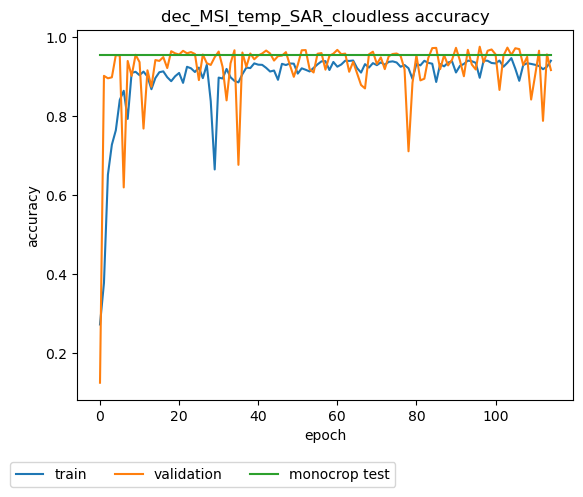

Monocrop test, image 44
3569.tif
1/1 [==============================] - 1s 1s/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 752440.0,
       0.0, -10.0, 644980.0)}


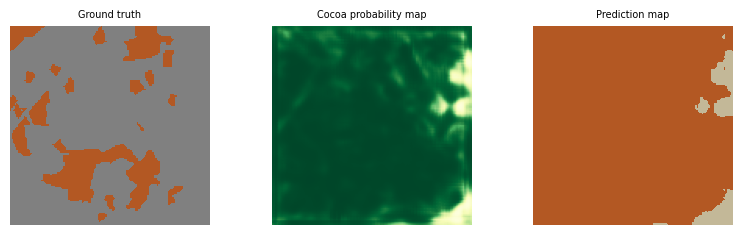

Monocrop test, image 29
1121.tif
1/1 [==============================] - 0s 21ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 716600.0,
       0.0, -10.0, 696180.0)}


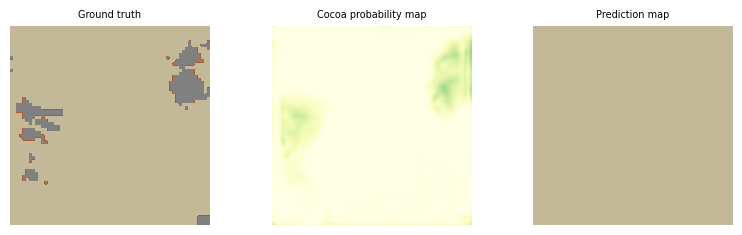

Monocrop test, image 27
4165.tif
1/1 [==============================] - 0s 21ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 761400.0,
       0.0, -10.0, 652660.0)}


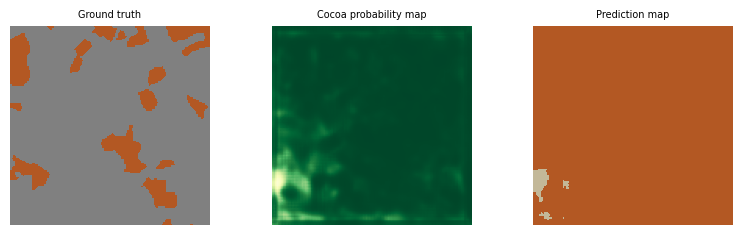

Monocrop test, image 6
727.tif
1/1 [==============================] - 0s 20ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 710200.0,
       0.0, -10.0, 650100.0)}


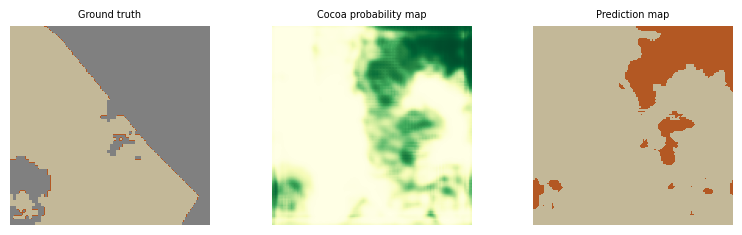

Monocrop test, image 1
640.tif
1/1 [==============================] - 0s 21ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 708920.0,
       0.0, -10.0, 651380.0)}


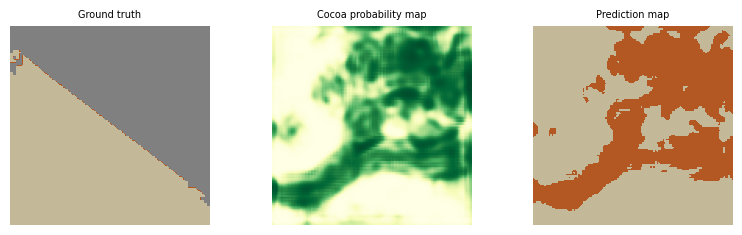

Monocrop test, image 18
5095.tif
1/1 [==============================] - 0s 21ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 775480.0,
       0.0, -10.0, 673140.0)}


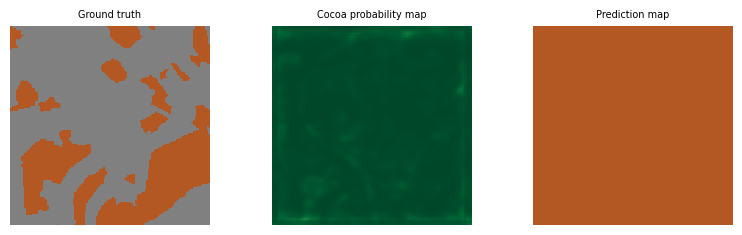

Intercrop test, image 0
2612.tif
1/1 [==============================] - 0s 21ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 738360.0,
       0.0, -10.0, 659060.0)}


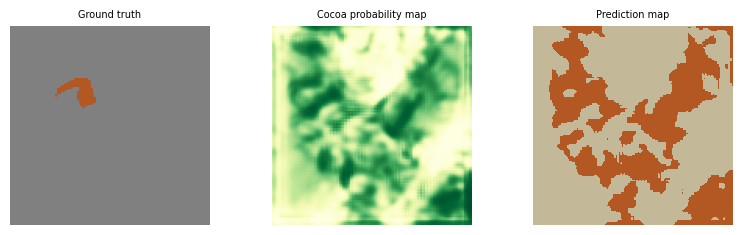

Intercrop test, image 10
3141.tif
1/1 [==============================] - 0s 21ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 746040.0,
       0.0, -10.0, 642420.0)}


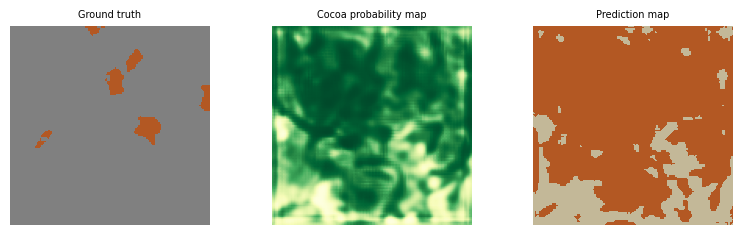

Intercrop test, image 16
3228.tif
1/1 [==============================] - 0s 23ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 747320.0,
       0.0, -10.0, 641140.0)}


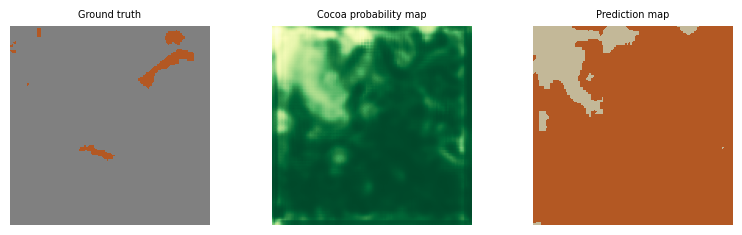

Intercrop test, image 22
3314.tif
1/1 [==============================] - 0s 23ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 748600.0,
       0.0, -10.0, 641140.0)}


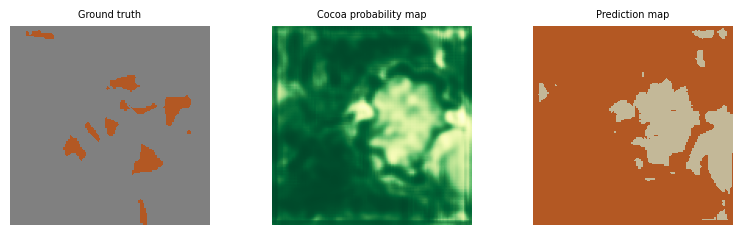

Intercrop test, image 28
3399.tif
1/1 [==============================] - 0s 23ms/step
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 749880.0,
       0.0, -10.0, 642420.0)}


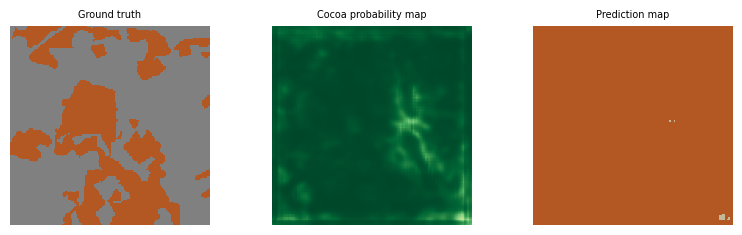

{'dataset': ['dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless', 'dec_MSI_temp_SAR_cloudless'], 'fold': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'runtime': [684.0610237121582, 586.1840198040009, 475.7216536998749, 608.7769820690155, 836.2570259571075, 1092.3287844657898, 386.67276906967163, 583.6351091861725, 739.1121408939362, 892.7877790927887], 'training_images': [434, 434, 434, 435, 435, 435, 435, 435, 435, 435], 'val_images': [49, 49, 49, 48, 48, 48, 48, 48, 48, 48], 'weights': [[1.8184100225809836, 15.247106854990019, 2.600896513254753], [1.7951800202526096, 14.758001481890426, 2.6652952844743445], [1.8261651194063122, 15.670072921923518, 2.573416490567362], [1.795680564657365, 14.990188180806692, 2.6567638434624294], [1.8243774574049805, 15.168207173519313, 2.59107333528926

In [ ]:
# set fold number
fold = 0
while fold < 10:
    
    def recall(y_true, y_pred):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, shape=(-1, 128, 128))
        # apply mask to exclude unknown regions
        y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        true_positives = K.sum(tf.where(y_true*y_pred==1, y_true, 0))
        possible_positives = K.sum(tf.where(y_true==1, y_true, 0))
        recall_keras = true_positives / (possible_positives + K.epsilon())

        return recall_keras


    def precision(y_true, y_pred):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, shape=(-1, 128, 128))
        # apply mask to exclude unknown regions
        y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        true_positives = K.sum(tf.where(y_true*y_pred==1, y_true, 0))
        predicted_positives = K.sum(tf.where(y_pred==1, y_pred, 0))
        precision_keras = true_positives / (predicted_positives + K.epsilon())

        return precision_keras
    
    def custom_accuracy(y_true, y_pred):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, shape=(-1, 128, 128))
        # apply mask to exclude unknown regions
        y_pred = tf.where(y_true == 0, tf.zeros_like(y_pred), y_pred)
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        true_positives_cocoa = K.sum(tf.where(y_true*y_pred==1, 1, 0))
        true_positives_forest = K.sum(tf.where(y_true*y_pred==4, 1, 0))
        total_predictions = K.sum(tf.where(y_true == 0, 0, 1))

        accuracy = (true_positives_cocoa+true_positives_forest)/total_predictions
        return accuracy

    X_train_fold = X_train[train_indices[fold]]
    y_train_fold = y_train[train_indices[fold]]
    X_valid_fold = X_train[val_indices[fold]]
    y_valid_fold = y_train[val_indices[fold]]
    report['fold'].append(fold)
    report['dataset'].append(dataset)
    report['training_images'].append(X_train_fold.shape[0])
    report['val_images'].append(X_valid_fold.shape[0])

    # COMPUTE CLASS WEIGHTS
    total_pixels = y_train_fold[:, :, :, :].size
    # print(total_pixels)

    class_weight = []

    # calculate class weights based on training data class labels distribution
    for label in np.unique(y_train_fold):
        # count how many pixels with this label
        label_count = np.count_nonzero(y_train_fold == label)
        # print(label_count)
        # calculate probability
        prob = (label_count/total_pixels)
        # print(prob)
        weight = 1/prob
        # print(weight)
        class_weight.append(weight)

    report['weights'].append(class_weight)
    class_weight=[0,class_weight[1], class_weight[2]]
    
        # Call the helper function for defining the layers for the model, given the input image size
    unet = UNetCompiled(input_size=(size, size, n_channels), n_filters=64, n_classes=n_classes)
    
        # loss calculated based on probability (i.e, value in [0., 1.] when from_logits=False) - this is the default
    unet.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss=loss_with_weights(class_weight),
                 metrics=[UpdatedIoU(num_classes=3, target_class_ids=[1], name='IOU'),
                          recall, precision, custom_accuracy])

    checkpoint_file = f"checkpoint_{dataset}_{fold}/cp.ckpt"

    checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_file,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

    start_time = time.time()

    results = unet.fit(X_train_fold,
                       y_train_fold,
                       batch_size=32,
                       epochs=300,
                       validation_data=(X_valid_fold, y_valid_fold),
                       callbacks=[checkpoint, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)])

    end_time = time.time()
    runtime = end_time-start_time
    report['runtime'].append(runtime)

    predictions = unet.predict(X_valid_fold)
    # print(predictions)
    IOU = results.history['IOU']
    val_IOU = results.history['val_IOU']

    loss = results.history['loss']
    val_loss = results.history['val_loss']

    recall = results.history['recall']
    val_recall = results.history['val_recall']

    precision = results.history['precision']
    val_precision = results.history['val_precision']

    accuracy = results.history['custom_accuracy']
    val_accuracy = results.history['val_custom_accuracy']
    
    unet.load_weights(checkpoint_file)
    # ckpt_reader = tf.train.load_checkpoint(checkpoint_file)
    # best_epoch = ckpt_reader.get_tensor("epoch")
    # report['epochs'].append(best_epoch)

    test_metrics_mono = unet.evaluate(X_test, y_test_mono)
    test_metrics_inter = unet.evaluate(X_inter, y_inter)


    report['monocrop_loss'].append(test_metrics_mono[0])
    report['monocrop_IOU'].append(test_metrics_mono[1])
    report['monocrop_precision'].append(test_metrics_mono[2])
    report['monocrop_recall'].append(test_metrics_mono[3])
    report['monocrop_accuracy'].append(test_metrics_mono[4])

    report['intercrop_loss'].append(test_metrics_inter[0])
    report['intercrop_IOU'].append(test_metrics_inter[1])
    report['intercrop_recall'].append(test_metrics_inter[2])
    report['intercrop_accuracy'].append(test_metrics_inter[4])
    
    F_1 = []
    val_F_1=[]
    for i in range(len(precision)):
        f1 = 2 * ((precision[i]*recall[i])/((precision[i]+recall[i]+0.001)))
        F_1.append(f1)

    for i in range(len(val_precision)):
        f1 = 2 * ((val_precision[i]*val_recall[i])/((val_precision[i]+val_recall[i]+0.001)))
        val_F_1.append(f1)

    mono_test_F_1 = 2 * ((test_metrics_mono[3]*test_metrics_mono[2])/(test_metrics_mono[3]+test_metrics_mono[2]))
    # mix_test_F_1 = 2 * ((test_metrics_mix[3]*test_metrics_mix[2])/(test_metrics_mix[3]+test_metrics_mix[2]))
    # inter_test_F_1 = 2 * ((test_metrics_inter[3]*test_metrics_inter[2])/(test_metrics_inter[3]+test_metrics_inter[2]))

    # list all data in history
    print(results.history.keys())

    # summarize history for loss
    plt.plot(loss)
    plt.plot(val_loss)
    plt.plot([0, len(loss)-1], [test_metrics_mono[0], test_metrics_mono[0]])
    # plt.plot([0, len(loss)-1], [test_metrics_mix[0], test_metrics_mix[0]])
    # plt.plot([0, len(loss)-1], [test_metrics_inter[0], test_metrics_inter[0]])
    plt.yscale('log')
    # plt.ylim(0, 50)
    plt.title(f'{dataset} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'monocrop test', 'mixed test', 'intercrop test'], bbox_to_anchor=(-0.15, -0.15), loc='upper left', ncol=6)
    plt.savefig(f'{dataset}/loss_{fold}.png',bbox_inches='tight')
    plt.show()


    # summarize history for IoU
    plt.plot(IOU)
    plt.plot(val_IOU)
    plt.plot([0, len(IOU)-1], [test_metrics_mono[1], test_metrics_mono[1]])
    # plt.plot([0, len(IOU)-1], [test_metrics_mix[1], test_metrics_mix[1]])
    # plt.plot([0, len(IOU)-1], [test_metrics_inter[1], test_metrics_inter[1]])
    plt.title(f'{dataset} IoU')
    plt.ylabel('IoU')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'monocrop test', 'mixed test', 'intercrop test'], bbox_to_anchor=(-0.15, -0.15), loc='upper left', ncol=6)

    plt.savefig(f'{dataset}/IoU_{fold}.png',bbox_inches='tight')
    plt.show()
    # summarize history for F1
    plt.plot(F_1)
    plt.plot(val_F_1)
    plt.plot([0, len(IOU)-1], [mono_test_F_1, mono_test_F_1])
    # plt.plot([0, len(IOU)-1], [mix_test_F_1, mix_test_F_1])
    # plt.plot([0, len(IOU)-1], [inter_test_F_1, inter_test_F_1])
    plt.title(f'{dataset} F1 score')
    plt.ylabel('F1 score')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'monocrop test', 'mixed test', 'intercrop test'], bbox_to_anchor=(-0.15, -0.15), loc='upper left', ncol=6)

    plt.savefig(f'{dataset}/F1_{fold}.png',bbox_inches='tight')
    plt.show()
    # summarize history for recall
    plt.plot(recall)
    plt.plot(val_recall)
    plt.plot([0, len(recall)-1], [test_metrics_mono[2], test_metrics_mono[2]])
    # plt.plot([0, len(recall)-1], [test_metrics_mix[2], test_metrics_mix[2]])
    # plt.plot([0, len(recall)-1], [test_metrics_inter[2], test_metrics_inter[2]])
    plt.title(f'{dataset} recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'monocrop test', 'mixed test', 'intercrop test'], bbox_to_anchor=(-0.15, -0.15), loc='upper left', ncol=6)

    plt.savefig(f'{dataset}/recall_{fold}.png',bbox_inches='tight')
    plt.show()
    # summarize history for precision
    plt.plot(precision)
    plt.plot(val_precision)
    plt.plot([0, len(precision)-1], [test_metrics_mono[3], test_metrics_mono[3]])
    # plt.plot([0, len(precision)-1], [test_metrics_mix[3], test_metrics_mix[3]])
    # plt.plot([0, len(precision)-1], [test_metrics_inter[3], test_metrics_inter[3]])
    plt.title(f'{dataset} precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'monocrop test', 'mixed test', 'intercrop test'], bbox_to_anchor=(-0.15, -0.15), loc='upper left', ncol=6)

    plt.savefig(f'{dataset}/precision_{fold}.png',bbox_inches='tight')
    plt.show()
    # summarize history for accuracy
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.plot([0, len(accuracy)-1], [test_metrics_mono[4], test_metrics_mono[4]])
    # plt.plot([0, len(accuracy)-1], [test_metrics_mix[4], test_metrics_mix[4]])
    # plt.plot([0, len(accuracy)-1], [test_metrics_inter[4], test_metrics_inter[4]])
    plt.title(f'{dataset} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'monocrop test', 'mixed test', 'intercrop test'], bbox_to_anchor=(-0.15, -0.15), loc='upper left', ncol=6)

    plt.savefig(f'{dataset}/accuracy_{fold}.png',bbox_inches='tight')
    plt.show()
    
    cmap = matplotlib.colors.ListedColormap(['grey', '#B35823', '#C3B898' ])
    
    if fold == 9:
        
        images = [44, 29, 27, 6, 1, 18]
        for i in images:
            x=i
            print(f'Monocrop test, image {i}')

            VisualizeResults(x, X_test, y_test_mono, y_test_file, cmap, title= f'{dataset}/visual_monocrop_test_{fold}_{x}', save='True')
            # print('Mixed crop test')
            # VisualizeResults(x, X_test, y_test_mix, cmap, title= f'{dataset}/visual_mixed_crop_test_{random}_{x}', save='True')
            # print('Intercrop test')
            # VisualizeResults(x, X_test, y_test_inter, cmap, title= f'{dataset}/visual_intercrop_test_{random}_{x}', save='True')

        images = [0,10,16,22,28]
        for i in images:
            x=i
            print(f'Intercrop test, image {i}')
            VisualizeResults(x, X_inter, y_inter, y_test_file=mask_inter, cmap=cmap, title= f'{dataset}/visual_monocrop_test_inter_{fold}_{x}', 
                             save='True', type= 'inter_mask')
    
    print(report)
    report_df = pd.DataFrame(report)
    report_df.to_csv(f'report_{dataset}.csv')    
    
    print(f'Fold #{fold} done!')
    fold+=1


In [ ]:
# print(report)
report_df = pd.DataFrame(report)

report_df.to_csv(f'report_{dataset}.csv')
print('training done!')

training done!
